<a href="https://colab.research.google.com/github/NicoEssi/Data_Science_Portfolio/blob/master/Stackoverflow_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

### Dependencies and Data

In [0]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Downloading the Stack Overflow Survey Results for 2019
!wget --no-check-certificate \
    "https://drive.google.com/uc?authuser=0&id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV&export=download" \
    -O "/tmp/soi_2019.zip"
zip_ref = zipfile.ZipFile("/tmp/soi_2019.zip", 'r')
zip_ref.extractall("/tmp/soi_2019")
zip_ref.close()

--2019-09-12 13:37:27--  https://drive.google.com/uc?authuser=0&id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV&export=download
Resolving drive.google.com (drive.google.com)... 108.177.119.101, 108.177.119.138, 108.177.119.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.119.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/uc?id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV&export=download [following]
--2019-09-12 13:37:27--  https://drive.google.com/uc?id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dc9r98kj6bifmuk6mm910agl4cul3asm/1568289600000/06716978924947585995/*/1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV?e=download [following]
--2019-09-12 13:37:28--  https://doc-14-4c-docs.googleusercontent.com/docs/secu

## Custom Functions

### Encoding functions

In [0]:
# Encode single label
def encode(data):
    return data.str.get_dummies()

# Encode multiple labels
def encodem(data):
    return data.str.get_dummies(sep=";")

### Parsing functions

In [0]:
# Parse all types within a data into a list
def parse_types(data):
    types_temp = []
    for i in range( len(data)):
        types_temp.append([parsed.strip() for parsed in str(data.iloc[i]).split(';')])
    
    types = []
    for i in types_temp:
        for j in i:
            if j not in types:
                types.append(j)
                
    return types

# Parse datarow of all text into a list
def parse(data):
    return [parsed.strip() for parsed in str(data).split(';')]

# Check whether text exists in data
def check(text, data):
    if text in parse(data):
        return 1
    else:
        return 0

# Count occurences of text in data
def countd(text, data):
    counted = []
    
    for i in data:
        counted.append(check(text, i))
    
    return sum(counted)


def copypaste(text, column, data):
    copypaste = []
    
    for i in range( len(data)):
        if check(text, data[column].iloc[i]):
            copypaste.append(data.iloc[i])
    
    return copypaste

### Salary functions

In [0]:
# Check salary for specific category
def check_average_salary(category, column, data):
    salaries = []
    for i in range( len(data) ):
        if category in parse(data[column].iloc[i]):
            salaries.append(data.CompTotal.iloc[i])
    return sum(salaries)/len(salaries)


# Check salary for specific column
def print_average_salary_column(column, data):
    for i in parse_types(data[column]):
        print(str(i) + ": " + str(check_average_salary(i, column, data)))
        

# Plot salary for specific column
#plt.rcParams['figure.figsize'] = [15, 5] # Set figure size
def average_salary_column(column, data, plot = False):
    ybucket = []
    xbucket = []
    for i in parse_types(data[column]):
        ybucket.append(check_average_salary(i, column, data))
        xbucket.append(i)
    bucket = pd.DataFrame(ybucket, xbucket)
    if plot:
        bucket.plot(kind = "bar")
        plt.show()
    else:
        return bucket

### Receive function

In [0]:
# Receive the rows with specified category in column within data
def receive(category, column, data):
    bucket = []
    for i in range( len(data) ):
        if category in parse(data[column].iloc[i]):
            bucket.append(data.iloc[i])
    return bucket

#len(pd.DataFrame(receive("Data scientist or machine learning specialist", "DevType", data_eu)))

### Currency functions

In [0]:
# currency rates as of 09/09/2019
"""
EUR = 1.10
CHF = 1.00
SEK = 0.10
NOK = 0.11
DKK = 0.15
USD = 1.00
GBP = 1.23
INR = 0.014
NZD = 0.64
AUD = 0.69
CAD = 0.76
"""

currencies = {"EUR" : 1.10
             ,"CHF" : 1.00
             ,"SEK" : 0.10
             ,"NOK" : 0.11
             ,"DKK" : 0.15
             ,"USD" : 1.00
             ,"GBP" : 1.23
             ,"INR" : 0.014
             ,"NZD" : 0.64
             ,"AUD" : 0.69
             ,"CAD" : 0.76}

# Convert currency into USD
def currency_usd(data):
    if data in (currencies):
        return currencies[data]
    else:
        return 0

# Annualize total compensation
def currency_annualize(data):
    if data == 'Weekly':
        return 52
    elif data == 'Monthly':
        return 12
    elif data == 'Yearly':
        return 1

# 1. Business- & Data Understanding

Read the data and initial exploration of questions to determine which features are important for further inquiry.

In [0]:
data = pd.read_csv("/tmp/soi_2019/survey_results_public.csv")
schema = pd.read_csv("/tmp/soi_2019/survey_results_schema.csv")

In [0]:
#for i in range(len(schema)):
#    print(schema.iloc[i].Column + " : " + schema.iloc[i].QuestionText)

Clean data of rows with missing salary information.

In [9]:
print("NA Count: " + str(np.sum(data.Country == "United States")
                        + np.sum(data.Country == "Canada")))
print("UK Count: " + str(np.sum(data.Country == "United Kingdom")))
print("EU Count: " + str(np.sum(data.Country == "France")
                        + np.sum(data.Country == "Germany")
                        + np.sum(data.Country == "Sweden")
                        + np.sum(data.Country == "Denmark")
                        + np.sum(data.Country == "Finland")
                        + np.sum(data.Country == "Ireland")
                        + np.sum(data.Country == "Netherlands")
                        + np.sum(data.Country == "Austria")
                        + np.sum(data.Country == "Belgium")
                        + np.sum(data.Country == "Switzerland")))

NA Count: 24344
UK Count: 5737
EU Count: 15591


In [10]:
print("Before: " + str(len(data.CompTotal)))

data = data[pd.notnull(data['CompFreq'])]
data = data[pd.notnull(data['CompTotal'])].reset_index(drop = True)

print("After: " + str(len(data.CompTotal)))

Before: 88883
After: 55827


In [11]:
print("NA Count: " + str(np.sum(data.Country == "United States")
                        + np.sum(data.Country == "Canada")))
print("UK Count: " + str(np.sum(data.Country == "United Kingdom")))
print("EU Count: " + str(np.sum(data.Country == "France")
                        + np.sum(data.Country == "Germany")
                        + np.sum(data.Country == "Sweden")
                        + np.sum(data.Country == "Denmark")
                        + np.sum(data.Country == "Finland")
                        + np.sum(data.Country == "Ireland")
                        + np.sum(data.Country == "Netherlands")
                        + np.sum(data.Country == "Austria")
                        + np.sum(data.Country == "Belgium")
                        + np.sum(data.Country == "Switzerland")
                        + np.sum(data.Country == "Norway")))

NA Count: 17238
UK Count: 4036
EU Count: 10744


In [12]:
devtypes = parse_types(data.DevType)
eduother = parse_types(data.EduOther)
languages = parse_types(data.LanguageWorkedWith)
databases = parse_types(data.DatabaseWorkedWith)
platforms = parse_types(data.PlatformWorkedWith)
webframes = parse_types(data.WebFrameWorkedWith)
misctechs = parse_types(data.MiscTechWorkedWith)

print(devtypes)
print(eduother)
print(languages)
print(databases)
print(platforms)
print(webframes)
print(misctechs)

['Designer', 'Developer, back-end', 'Developer, front-end', 'Developer, full-stack', 'Data or business analyst', 'Data scientist or machine learning specialist', 'Database administrator', 'Engineer, data', 'Developer, QA or test', 'DevOps specialist', 'Developer, desktop or enterprise applications', 'Developer, game or graphics', 'Educator', 'Developer, mobile', 'Engineer, site reliability', 'Engineering manager', 'Senior executive/VP', 'System administrator', 'Student', 'Developer, embedded applications or devices', 'Product manager', 'Academic researcher', 'Scientist', 'nan', 'Marketing or sales professional']
['Taught yourself a new language, framework, or tool without taking a formal course', 'Taken an online course in programming or software development (e.g. a MOOC)', 'Received on-the-job training in software development', 'Participated in a full-time developer training program or bootcamp', 'Taken a part-time in-person course in programming or software development', 'Participate

## We are interested in creating a model that can accurately predict salaries based on numerous factors within each region.

### Why do we group up many countries together into a single dataset for EU data?
Professionals residing within the European Union have liberties granted to them by the Schengen agreement, which enables free movement of labor force and thus professionals can freely work wherever they wish.

### Why are Norway and Switzerland included in the European dataset?
While they are not part of the European Union, they have signed agreements in association with the Schengen agreement.

### Why is the United Kingdom not included in the European dataset despite having signed an agreement in association with the Schengen agreement?
Brexit. Despite the fact that the data has been gathered prior to the secession deadline, it would still be interesting to inquire on the UK data separately in case it would be of interest to compare changes in 2020 and onwards. And as of writing this, nothing has been officially said regarding future signed agreement in association with the Schengen agreement for UK.

### Why are the countries in APT / RCEP not included?
Unfortunately the data gathered for China, South Korea, and Japan are too small to make reliable inferences - and there are currently significant restrictions in freedom of movement for professionals between these countries, making it unreasonable to conduct an inquiry on these countries as a collective.

# 2. Data Preparation

In [13]:
del data['Respondent']

print(len(data))

data = data[data["MainBranch"] == 'I am a developer by profession']
data = data[data["LastHireDate"] != "I've never had a job"]

print(len(data))

55827
50397


Total compensation preprocessing and calibration.

In [0]:
y_label = data.CompTotal * data.CompFreq.apply(currency_annualize)
y_label = y_label * data.CurrencySymbol.apply(currency_usd)

In [15]:
y = y_label.copy()

y = y[y < 500000]
y = y[y > 15000]

pd.set_option('float_format', '{:f}'.format)
y.describe(percentiles = [.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

count    32278.000000
mean     86846.166500
std      64512.145260
min      15036.000000
1%       16800.000000
10%      30250.000000
20%      40858.632000
30%      50400.000000
40%      60000.000000
50%      70000.000000
60%      82500.000000
70%      99000.000000
80%     120000.000000
90%     156000.000000
99%     376380.000000
max     499200.000000
dtype: float64

In [0]:
relevant = ["Hobbyist", "OpenSourcer", "Employment", "Country",
            "Student", "EdLevel", "UndergradMajor", "EduOther",
            "OrgSize","DevType", "YearsCodePro", "JobSeek",
            "LastHireDate", "FizzBuzz", "LanguageWorkedWith",
            "DatabaseWorkedWith", "PlatformWorkedWith",
            "WebFrameWorkedWith", "MiscTechWorkedWith",
           "CompTotal", "CompFreq", "CurrencySymbol"]


# Handling the NA dataset
data_na = data[data["Country"].isin(["United States", "Canada"])]
data_na = data_na[relevant]

data_na["CompTotal"] *= data_na.CompFreq.apply(currency_annualize)
data_na["CompTotal"] *= data_na.CurrencySymbol.apply(currency_usd)
del data_na["CompFreq"]
del data_na["CurrencySymbol"]
data_na = data_na[data_na["CompTotal"] < 500000]
data_na = data_na[data_na["CompTotal"] > 15000]


# Handling the UK dataset
data_uk = data[data["Country"] == "United Kingdom"]
data_uk = data_uk[relevant]

data_uk["CompTotal"] *= data_uk.CompFreq.apply(currency_annualize)
data_uk["CompTotal"] *= data_uk.CurrencySymbol.apply(currency_usd)
del data_uk["CompFreq"]
del data_uk["CurrencySymbol"]
#del data_uk["Country"] # Needs to remain for the custom functions to work
data_uk = data_uk[data_uk["CompTotal"] < 500000]
data_uk = data_uk[data_uk["CompTotal"] > 15000]


# Handling the EU dataset
data_eu = data[data["Country"].isin(["France", "Germany", "Sweden",
                                     "Denmark", "Finland", "Norway",
                                     "Ireland", "Netherlands", "Austria",
                                     "Belgium", "Switzerland"])]
data_eu = data_eu[relevant]

data_eu["CompTotal"] *= data_eu.CompFreq.apply(currency_annualize)
data_eu["CompTotal"] *= data_eu.CurrencySymbol.apply(currency_usd)
del data_eu["CompFreq"]
del data_eu["CurrencySymbol"]
data_eu = data_eu[data_eu["CompTotal"] < 500000]
data_eu = data_eu[data_eu["CompTotal"] > 15000]

# 3. Data Exploration

In [37]:
for i in relevant:
    print(i + ": ")
    print(data[i].unique())
    
"""
Hobbyist: onehotencode   ///tested: not significant
OpenSourcer: onehotencoding   ///tested: significant
Employment: onehotencoding   ///assumed significant
Country: onehotencoding   ///assumed significant
Student: onehotencoding   ///assumed significant
EdLevel: onehotencoding   ///see FAQ @readme
UndergradMajor: onehotencoding   ///see FAQ @readme
EduOther: multilabelencoder   ///see FAQ @readme
OrgSize: onehotencoding   ///
DevType: multilabelencoder   ///assumed significant
YearsCode: numerical   ///
YearsCodePro: numerical   ///
JobSeek: onehotencoding   ///
LastHireDate: onehotencoding   /// will not be used as data for salary increase necessary
FizzBuzz: onehotencode   ///tested: significant
CompTotal : y
Languages: multilabel   ///test through reg
Database: multilabel   ///test through reg
Platform: multilabel   ///test through reg
Webframes: multilabel   ///test through reg
MiscTech: multilabel   ///test through reg
"""

Hobbyist: 
['No' 'Yes']
OpenSourcer: 
['Never' 'Once a month or more often'
 'Less than once a month but more than once per year'
 'Less than once per year']
Employment: 
['Employed full-time'
 'Independent contractor, freelancer, or self-employed'
 'Employed part-time' nan]
Country: 
['United States' 'New Zealand' 'India' 'Germany' 'United Kingdom'
 'Australia' 'Brazil' 'Israel' 'South Africa' 'Switzerland' 'Argentina'
 'Czech Republic' 'Spain' 'Serbia' 'Poland' 'Sweden' 'China' 'Netherlands'
 'Philippines' 'Ireland' 'Pakistan' 'Austria' 'Canada' 'Croatia'
 'Russian Federation' 'Italy' 'Estonia' 'Turkey' 'Romania' 'Finland'
 'Viet Nam' 'Slovenia' 'Iran' 'Hungary' 'Latvia' 'Hong Kong (S.A.R.)'
 'United Arab Emirates' 'France' 'Bulgaria' 'Nicaragua' 'Denmark' 'Japan'
 'Bangladesh' 'Ukraine' 'Mexico' 'Ecuador' 'Singapore' 'South Korea'
 'Egypt' 'Norway' 'Portugal' 'Belgium' 'Nigeria' 'Afghanistan' 'Mongolia'
 'Chile' 'Malaysia' 'Luxembourg' 'Dominican Republic' 'Cape Verde' 'Peru'
 'Nepa

'\nHobbyist: onehotencode   ///tested: not significant\nOpenSourcer: onehotencoding   ///tested: significant\nEmployment: onehotencoding   ///assumed significant\nCountry: onehotencoding   ///assumed significant\nStudent: onehotencoding   ///assumed significant\nEdLevel: onehotencoding   ///see FAQ @readme\nUndergradMajor: onehotencoding   ///see FAQ @readme\nEduOther: multilabelencoder   ///see FAQ @readme\nOrgSize: onehotencoding   ///\nDevType: multilabelencoder   ///assumed significant\nYearsCode: numerical   ///\nYearsCodePro: numerical   ///\nJobSeek: onehotencoding   ///\nLastHireDate: onehotencoding   ///\nFizzBuzz: onehotencode   ///tested: significant\nCompTotal : y\nLanguages: multilabel   ///test through reg\nDatabase: multilabel   ///test through reg\nPlatform: multilabel   ///test through reg\nWebframes: multilabel   ///test through reg\nMiscTech: multilabel   ///test through reg\n'

In [0]:
#hob = encode(data["Hobbyist"])
#ope = encode(data["OpenSourcer"])

data_eu_model = pd.concat([encode(data["Hobbyist"]),
                           encode(data["OpenSourcer"]),
                           encodem(data["DevType"])], axis = 1)
#encodem(data["DevType"])

## 3.1. t-Test for Statistical Significance of Hobbyist

In [17]:
bucket_yes = pd.DataFrame(receive("Yes", "Hobbyist", data_eu))
bucket_no = pd.DataFrame(receive("No", "Hobbyist", data_eu))

bucket_yes = bucket_yes["CompTotal"].sample(1400)
bucket_no = bucket_no["CompTotal"].sample(1400)

# t-Test on FizzBuzz
from scipy.stats import ttest_ind

print('Yes : mean = %.3f, stdv = %.3f' % (np.mean(bucket_yes), np.std(bucket_yes)))
print('No : mean = %.3f, stdv = %.3f' % (np.mean(bucket_no), np.std(bucket_no)))

# Fail to reject H0: Sample distributions are equal.
# Reject H0: Sample distributions are not equal.

stat, p = ttest_ind(bucket_yes, bucket_no)
print('Statistics = %.3f, p = %.3f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Yes : mean = 66367.944, stdv = 46477.625
No : mean = 66989.416, stdv = 51120.748
Statistics = -0.336, p = 0.737
Same distributions (fail to reject H0)


## 3.2. Significance of OpenSourcer

In [18]:
opensourcer_salary = average_salary_column("OpenSourcer", data_eu).sort_values(0)

print("Never: " + str(len(data_eu[data_eu["OpenSourcer"] == "Never"]))
     + "\n<1/year: " + str(len(data_eu[data_eu["OpenSourcer"] == "Less than once per year"]))
      +"\n<1/month: " + str(len(data_eu[data_eu["OpenSourcer"] == "Less than once a month but more than once per year"]))
      +"\n>=1/month: " + str(len(data_eu[data_eu["OpenSourcer"] == "Once a month or more often"])))

opensourcer_salary

Never: 2515
<1/year: 2612
<1/month: 2369
>=1/month: 1133


,0
Never,62722.573042
Less than once per year,65057.164587
Less than once a month but more than once per year,67282.168852
Once a month or more often,73081.324325


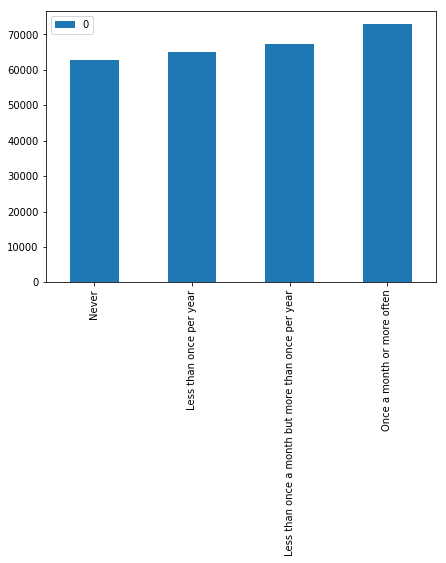

In [19]:
plt.rcParams['figure.figsize'] = [7, 5]
opensourcer_salary.plot(kind = "bar")
plt.show()

# We can clearly see an upward trend.
# Salary tends to increase with involvement of opensource contribution.

## 3.3. Significance of Employment

In [20]:
employment_salary = average_salary_column("Employment", data_eu).sort_values(0)

employment_salary

# I don't think I need to say anything here. Results are common sense.
# We will exclude nan and contractor from model building/training.

,0
Employed part-time,46924.330228
Employed full-time,64097.025426
nan,67180.000000
"Independent contractor, freelancer, or self-employed",100588.814431


## 3.4. Significance of Country

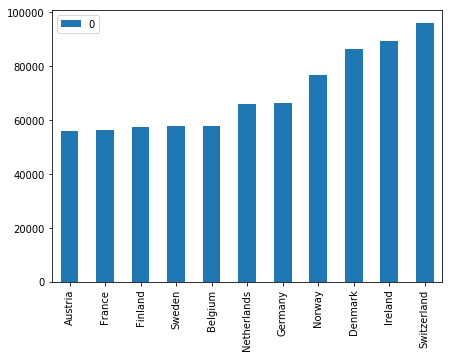

In [21]:
country_salary = average_salary_column("Country", data_eu).sort_values(0).plot(kind = "bar")

# We can very clearly see that there is a significance in country.
# Further information can be found at Harnham's salary guide 2019.
# link: https://www.harnham.com/salary-guide

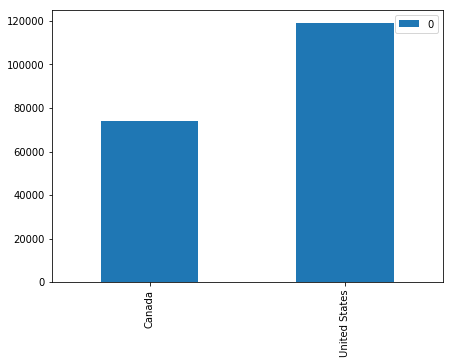

In [22]:
country_salary = average_salary_column("Country", data_na).sort_values(0).plot(kind = "bar")

## 3.5. Does it matter if you study while working?

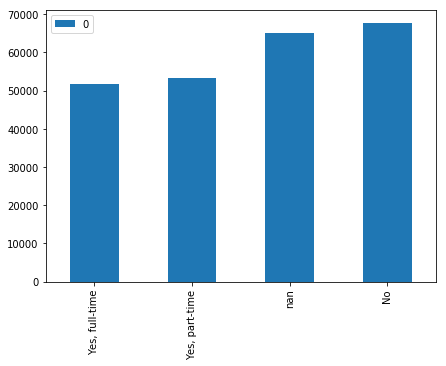

In [23]:
students_salary = average_salary_column("Student", data_eu).sort_values(0).plot(kind = "bar")

# We can see that it definitely matters whether you study (full-time or part-time) or not.
# However, we need to ask ourselves whether it's because those studying are working
# full- or part-time as well, which might impact the salary.

In [0]:
print(data_eu["Student"].isna().sum())

print(len(data_eu["Student"]))

# The number of nan is so insignificantly small that we can either assume
# that they are people who didn't bother answering "No", or just remove
# those rows when training our model. We might try both, and check val results.

37
8629


## 3.6. Does it matter what you studied?

In [0]:
ed_salary = average_salary_column("EdLevel", data_eu).sort_values(0)
ed_salary.plot(kind = "bar")

# We can see that there are definitely differences but it's not necessarily
# in an intuitive order, as we can see PhD earning less than BSc and MSc,
# and those who didn't complete formal education earn more than those with MSc.

# However, we will still include EdLevel and measure through our validation
# results of the model on whether they contribute or not to increased accuracy.

In [0]:
ed_salary

,0
"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",58859.865276
nan,59040.686294
Associate degree,59131.154487
"Professional degree (JD, MD, etc.)",60094.771200
Some college/university study without earning a degree,60958.882334
"Bachelor’s degree (BA, BS, B.Eng., etc.)",65681.247921
"Master’s degree (MA, MS, M.Eng., MBA, etc.)",68873.508624
I never completed any formal education,70525.412500
Primary/elementary school,72268.832432
"Other doctoral degree (Ph.D, Ed.D., etc.)",81371.727907


## 3.7. What about other non-formal education?

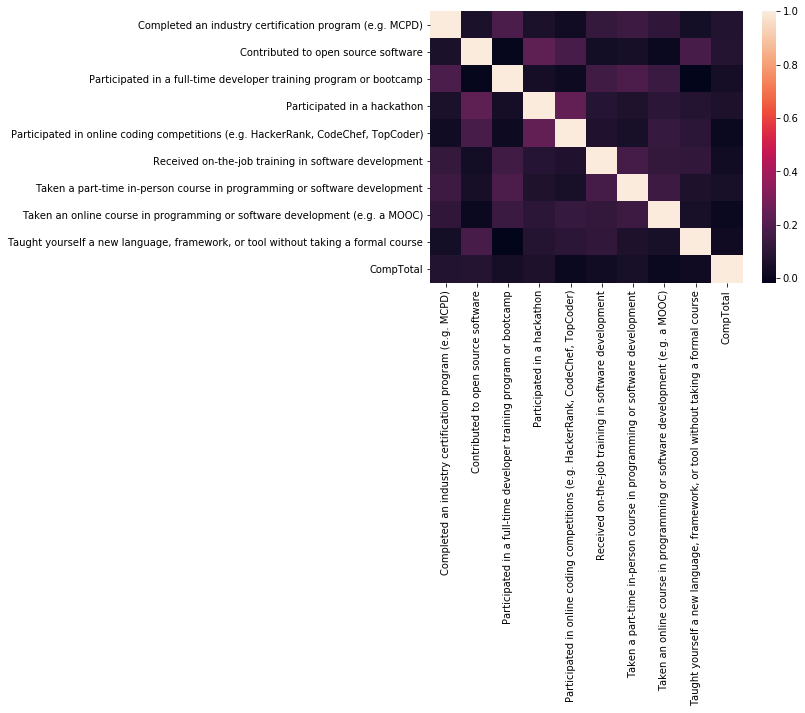

In [0]:
data_eu_test = data_eu[data_eu["CompTotal"] < 90000]
data_eu_test = data_eu[data_eu["CompTotal"] > 15000]

data_test = pd.concat([encodem(data_eu_test["EduOther"]),
                       data_eu_test["CompTotal"]], axis = 1)

data_test.CompTotal = (data_test.CompTotal - min(data_test.CompTotal)) / (max(data_test.CompTotal) - min(data_test.CompTotal))

sns.heatmap(data_test.corr())

# We can see that there's a significant correlation, even if it isn't very visible.
# Let us take a look at the actual numbers.

In [0]:
data_test.corr().sort_values("CompTotal").CompTotal
# Yes, we can see that there's as much as 8% correlation with increased salary,
# which is definitely significant as far as salaries go.

Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)    0.007894
Taken an online course in programming or software development (e.g. a MOOC)         0.008089
Taught yourself a new language, framework, or tool without taking a formal course   0.023928
Received on-the-job training in software development                                0.027758
Participated in a full-time developer training program or bootcamp                  0.042248
Taken a part-time in-person course in programming or software development           0.047842
Participated in a hackathon                                                         0.059957
Completed an industry certification program (e.g. MCPD)                             0.077395
Contributed to open source software                                                 0.080192
CompTotal                                                                           1.000000
Name: CompTotal, dtype: float64

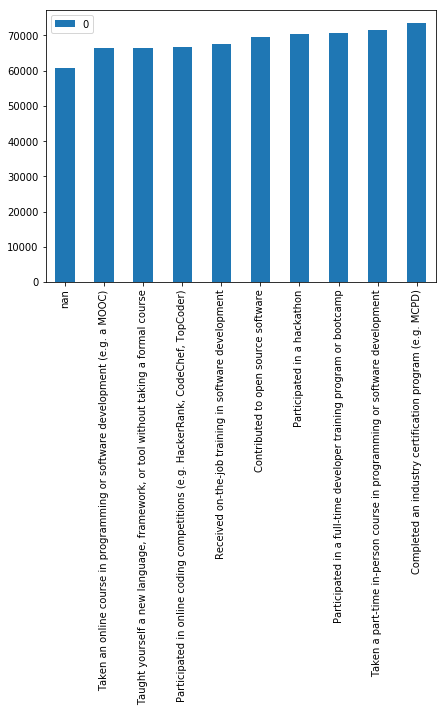

In [30]:
oed_salary = average_salary_column("EduOther", data_eu).sort_values(0)
oed_salary.plot(kind = "bar")

## 3.8. How does organizational size impact salary?

In [39]:
org_salary = average_salary_column("OrgSize", data_eu).sort_values(0)
org_salary

# We can see that there's a significant climb, even if we disregard
# the sole proprietors/freelancers.

,0
nan,55889.805556
10 to 19 employees,58872.732735
2-9 employees,60808.717832
20 to 99 employees,61672.755349
100 to 499 employees,64440.230954
"1,000 to 4,999 employees",65139.949760
500 to 999 employees,66992.048423
"5,000 to 9,999 employees",69750.472474
"10,000 or more employees",76807.673506
"Just me - I am a freelancer, sole proprietor, etc.",99432.160401


In [42]:
print("1: " + str(len(data_eu[data_eu["OrgSize"] == "Just me - I am a freelancer, sole proprietor, etc."]))
     +"\n2-9: " + str(len(data_eu[data_eu["OrgSize"] == "2-9 employees"]))
     +"\n10-19: " + str(len(data_eu[data_eu["OrgSize"] == "10 to 19 employees"]))
     +"\n20-99: " + str(len(data_eu[data_eu["OrgSize"] == "20 to 99 employees"]))
     +"\n100-499: " + str(len(data_eu[data_eu["OrgSize"] == "100 to 499 employees"]))
     +"\n500-999: " + str(len(data_eu[data_eu["OrgSize"] == "500 to 999 employees"]))
     +"\n1000-4999: " + str(len(data_eu[data_eu["OrgSize"] == "1,000 to 4,999 employees"]))
     +"\n5000-9999: " + str(len(data_eu[data_eu["OrgSize"] == "5,000 to 9,999 employees"]))
     +"\n10000+: " + str(len(data_eu[data_eu["OrgSize"] == "10,000 or more employees"])))

print("nan :" + str(data_eu["OrgSize"].isna().sum()))

1: 399
2-9: 867
10-19: 947
20-99: 2176
100-499: 1583
500-999: 539
1000-4999: 835
5000-9999: 287
10000+: 924
nan :72


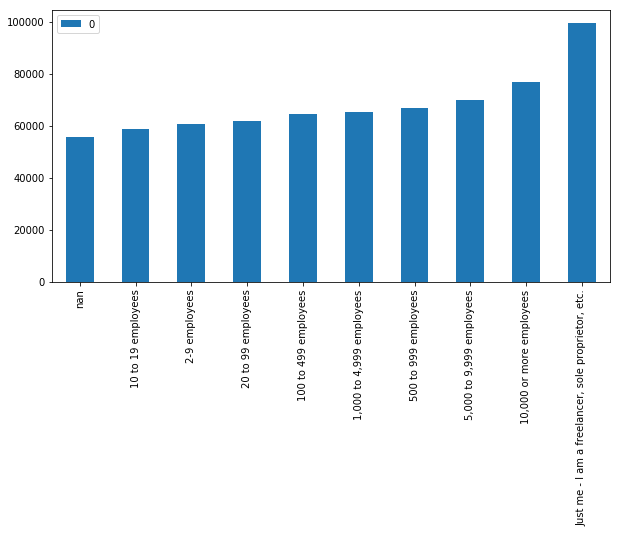

In [40]:
org_salary.plot(kind = "bar")

## 3.9. Relationship between professional code experience and salary

41 size: 1


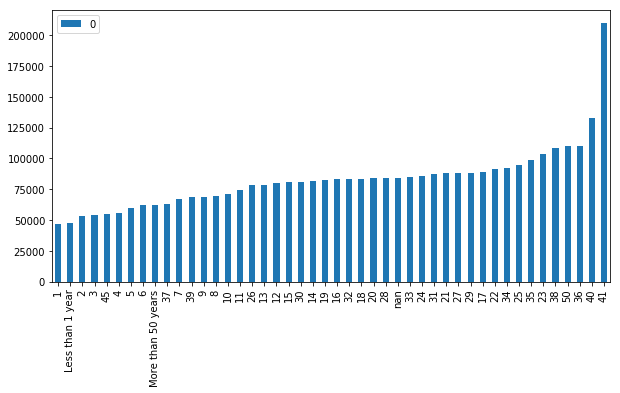

In [46]:
exp_salary = average_salary_column("YearsCodePro", data_eu).sort_values(0)
exp_salary.plot(kind = "bar")

# Nothing unexpected apart from the extreme outlier with "41".

In [53]:
print("41 sample size: " + str(len(data_eu[data_eu["YearsCodePro"] == "41"])))

# Because we only have one sample of it. That's why.
# We will disregard it during training, as it doesn't fit well between 40 and 50.

41 sample size: 1


## 3.10. Are those actively seeking a job receiving a greater salary?

In [0]:
JobSeek: onehotencoding   ///
LastHireDate: onehotencoding   ///

In [0]:
data_eu.DevType.iloc[5]

data_eu.CompTotal.iloc[5]

data_eu.Country.iloc[5]

parse(data_eu.DevType.iloc[5])

['Data or business analyst',
 'Data scientist or machine learning specialist',
 'Database administrator',
 'Designer',
 'Developer, back-end',
 'Developer, desktop or enterprise applications',
 'Developer, front-end',
 'Developer, full-stack',
 'Educator',
 'Marketing or sales professional',
 'Student',
 'System administrator']

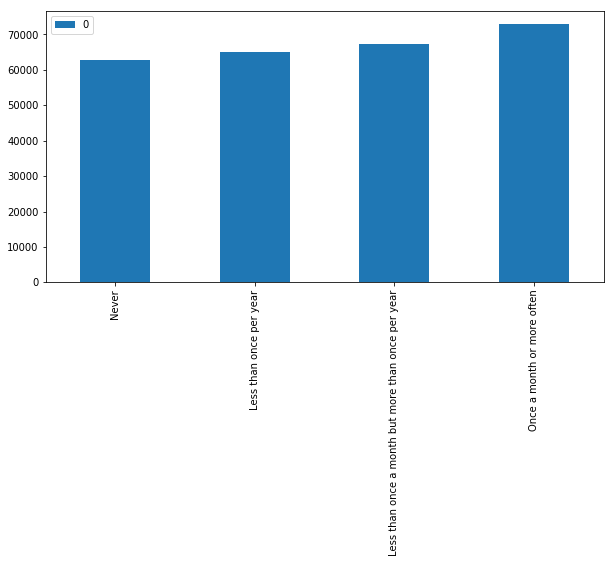

In [36]:
plt.rcParams['figure.figsize'] = [10, 5]
average_salary_column("OpenSourcer", data_eu).sort_values(0).plot(kind = "bar")
#plot_average_salary_column("DevType", data_eu[data_eu["Country"].isin(["Sweden"])])

#n, bins, patches = plt.hist(data_na.CompTotal, 100, density = 1, facecolor = "blue", alpha = 0.5)
plt.show()

#check_average_salary_column("LanguageWorkedWith", data_eu[data_eu["Country"].isin(["Sweden"])])

#check_average_salary("Data scientist or machine learning specialist", "DevType", data_eu)

## 3.11. t-Test for Statistical Significance of FizzBuzz

In [0]:
bucket_yes = pd.DataFrame(receive("Yes", "FizzBuzz", data_eu))
bucket_no = pd.DataFrame(receive("No", "FizzBuzz", data_eu))

bucket_yes = bucket_yes["CompTotal"].sample(800)
bucket_no = bucket_no["CompTotal"].sample(800)

# t-Test on FizzBuzz
from scipy.stats import ttest_ind

print('Yes : mean = %.3f, stdv = %.3f' % (np.mean(bucket_yes), np.std(bucket_yes)))
print('No : mean = %.3f, stdv = %.3f' % (np.mean(bucket_no), np.std(bucket_no)))

# Fail to reject H0: Sample distributions are equal.
# Reject H0: Sample distributions are not equal.

stat, p = ttest_ind(bucket_yes, bucket_no)
print('Statistics = %.3f, p = %.3f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Yes : mean = 71119.653, stdv = 48212.439
No : mean = 64090.088, stdv = 43321.897
Statistics = 3.066, p = 0.002
Different distributions (reject H0)


In [0]:
# Above test is subject to chance due to sampling randomness.
# By taking the average of many tests, we eliminate some randomness

results = []
bucket_yes = pd.DataFrame(receive("Yes", "FizzBuzz", data_eu))
bucket_no = pd.DataFrame(receive("No", "FizzBuzz", data_eu))

for i in range(10000):
    data1 = bucket_yes["CompTotal"].sample(800)
    data2 = bucket_no["CompTotal"].sample(800)
    stat, p = ttest_ind(data1, data2)
    
    results.append(p)
    
p = sum(results)/len(results)

print("p : " + str(p))

alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')
    

p : 0.03913977262707516
Different distributions (reject H0)


# 4. Model Data

# 5. Results